In [1]:
!pip install transformers
!pip install datasets
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
from google.colab import files
uploaded = files.upload()

Saving fil_data.csv to fil_data.csv


In [4]:
df = pd.read_csv('fil_data.csv')
texts = df['utterance'].tolist()
labels = df['label'].tolist()

In [5]:
class_counts = df['label'].value_counts()
if abs(class_counts[0] - class_counts[1]) > 0:
    print("Class imbalance detected. Consider oversampling or undersampling.")


Class imbalance detected. Consider oversampling or undersampling.


In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, stratify=labels)


In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [8]:
def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128)


In [9]:
train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

In [10]:
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

In [11]:
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

In [12]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [14]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,               # Increase epochs
    per_device_train_batch_size=16,   # Increase batch size
    per_device_eval_batch_size=32,
    warmup_steps=500,
    learning_rate=5e-5,               # Adjust learning rate
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,      # Use best model
    metric_for_best_model="f1",
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [16]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.397700,0.380024,0.834409,0.760173,0.783835,0.771823
2,0.332600,0.398068,0.834839,0.757621,0.790714,0.773814
3,0.278800,0.412226,0.835822,0.749089,0.812726,0.779611
4,0.200100,0.472045,0.834900,0.758940,0.788306,0.773345


TrainOutput(global_step=16276, training_loss=0.3423494853209324, metrics={'train_runtime': 6007.8821, 'train_samples_per_second': 43.343, 'train_steps_per_second': 2.709, 'total_flos': 1.7128529703936e+16, 'train_loss': 0.3423494853209324, 'epoch': 4.0})

In [17]:
results = trainer.evaluate()
print("Evaluation Results:", results)


Evaluation Results: {'eval_loss': 0.4122259020805359, 'eval_accuracy': 0.8358218125960062, 'eval_precision': 0.7490886035821842, 'eval_recall': 0.812725709372313, 'eval_f1': 0.7796106895414054, 'eval_runtime': 102.6927, 'eval_samples_per_second': 158.482, 'eval_steps_per_second': 4.957, 'epoch': 4.0}


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.85      0.87     10460
     Class 1       0.75      0.81      0.78      5815

    accuracy                           0.84     16275
   macro avg       0.82      0.83      0.82     16275
weighted avg       0.84      0.84      0.84     16275

Confusion Matrix:
[[8877 1583]
 [1089 4726]]


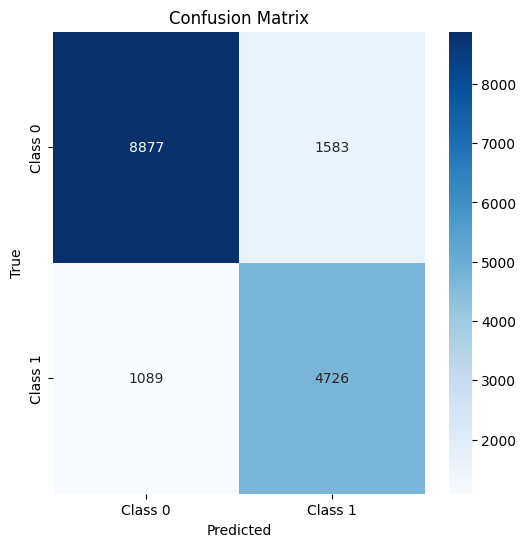

In [18]:
# Import necessary libraries for evaluation
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions on the validation set
predictions = trainer.predict(val_dataset)

# Extract the true labels and predicted labels
true_labels = predictions.label_ids
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Generate classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1"]))

# Generate confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Optionally, visualize the confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
